<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/GAN/GAN_107_GAN_Evaluation_FID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluation

The notebook implements code to evaluate GANs

Here are the main features

* Download Celeb dataset from google drive (not working - grive issue)
* Download pretrained inception model and clip model 
* calculate FID on real and fake sample of celeb dataset by using inception n/w features

---

### Task
Celeb Dataset, evaluate model using FID.

### Reference
https://nbviewer.org/github/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%201/C2W1_Assignment.ipynb

## Challenges With Evaluating GANs


**Loss is Uninformative of Performance**

One aspect that makes evaluating GANs challenging is that the loss tells us little about their performance. Unlike with classifiers, where a low loss on a test set indicates superior performance, a low loss for the generator or discriminator suggests that learning has stopped.

**No Clear Non-human Metric**

If you define the goal of a GAN as "generating images which look real to people" then it's technically possible to measure this directly: you can ask people to act as a discriminator. However, this takes significant time and money so ideally you can use a proxy for this. There is also no "perfect" discriminator that can differentiate reals from fakes - if there were, a lot of machine learning tasks would be solved ;)

## Generator

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)


### Loading the Pre-trained Model

Now, you can set the arguments for the model and load the dataset:

    z_dim: the dimension of the noise vector
    image_size: the image size of the input to Inception (more details in the following section)
    device: the device type



In [2]:
z_dim = 64
image_size = 299
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
CelebA(".", download=True)
# celeba_data = datasets.ImageFolder(data_root, transforms=...)

# dataset = CelebA(".", download=True, transform=transform)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

BadZipFile: ignored

In [3]:
!git clone https://github.com/pankajr141/experiments.git

Cloning into 'experiments'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 315 (delta 73), reused 26 (delta 10), pack-reused 167
Receiving objects: 100% (315/315), 85.12 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [4]:
!ls -lh experiments/Reasoning/GAN/pretrained_models/

total 25M
-rw-r--r-- 1 root root  22M Dec  3 09:36 pretrained_celeba.pth.zip
-rw-r--r-- 1 root root 3.0M Dec  3 09:36 pretrained_classifier.pth.zip


In [5]:
!unzip experiments/Reasoning/GAN/pretrained_models/pretrained_celeba.pth.zip
!unzip experiments/Reasoning/GAN/pretrained_models/pretrained_classifier.pth.zip

Archive:  experiments/Reasoning/GAN/pretrained_models/pretrained_celeba.pth.zip
  inflating: pretrained_celeba.pth   
Archive:  experiments/Reasoning/GAN/pretrained_models/pretrained_classifier.pth.zip
  inflating: pretrained_classifier.pth  


In [6]:
ls

celeba/       pretrained_celeba.pth      sample_data/
experiments/  pretrained_classifier.pth


In [7]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()


### Inception-v3 Network
Inception-V3 is a neural network trained on ImageNet to classify objects. You may recall from the lectures that ImageNet has over 1 million images to train on. As a result, Inception-V3 does a good job detecting features and classifying images. Here, you will load Inception-V3 as inception_model.

In [10]:
!wget https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth

--2021-12-03 09:47:42--  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.224.160.98, 13.224.160.7, 13.224.160.89, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.160.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108857766 (104M) [application/octet-stream]
Saving to: ‘inception_v3_google-1a9a5a14.pth’

inception_v3_google 100%[===================>] 103.81M  67.2MB/s    in 1.5s    

2021-12-03 09:47:43 (67.2 MB/s) - ‘inception_v3_google-1a9a5a14.pth’ saved [108857766/108857766]



In [11]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Fréchet Inception Distance

Fréchet Inception Distance (FID) was proposed as an improvement over Inception Score and still uses the Inception-v3 network as part of its calculation. However, instead of using the classification labels of the Inception-v3 network, it uses the output from an earlier layer—the layer right before the labels. This is often called the feature layer. Research has shown that deep convolutional neural networks trained on difficult tasks, like classifying many classes, build increasingly sophisticated representations of features going deeper into the network. For example, the first few layers may learn to detect different kinds of edges and curves, while the later layers may have neurons that fire in response to human faces.

To get the feature layer of a convolutional neural network, we can replace the final fully connected layer with an identity layer that simply returns whatever input it received, unchanged. This essentially removes the final classification layer and leaves you with the intermediate outputs from the layer before.

In [12]:
inception_model.fc = torch.nn.Identity() 

Fréchet distance uses the values from the feature layer for two sets of images, say reals and fakes, and compares different statistical properties between them to see how different they are. Specifically, Fréchet distance finds the shortest distance needed to walk along two lines, or two curves, simultaneously. The most intuitive explanation of Fréchet distance is as the "minimum leash distance" between two points. Imagine yourself and your dog, both moving along two curves. If you walked on one curve and your dog, attached to a leash, walked on the other at the same pace, what is the least amount of leash that you can give your dog so that you never need to give them more slack during your walk? Using this, the Fréchet distance measures the similarity between these two curves.

The basic idea is similar for calculating the Fréchet distance between two probability distributions. You'll start by seeing what this looks like in one-dimensional, also called univariate, space.

**Univariate Fréchet Distance**

You can calculate the distance between two normal distributions X and Y with means μX and μY and standard deviations σX and σY

, as:
d(X,Y)=(μX−μY)2+(σX−σY)2

Pretty simple, right? Now you can see how it can be converted to be used in multi-dimensional, which is also called multivariate, space.

**Multivariate Fréchet Distance** - covariance

To find the Fréchet distance between two multivariate normal distributions, you first need to find the covariance instead of the standard deviation. The covariance, which is the multivariate version of variance (the square of standard deviation), is represented using a square matrix where the side length is equal to the number of dimensions. Since the feature vectors you will be using have 2048 values/weights, the covariance matrix will be 2048 x 2048. But for the sake of an example, this is a covariance matrix in a two-dimensional space:

Σ=(1001)

The value at location (i,j)
corresponds to the covariance of vector i with vector j. Since the covariance of i with j and j with i

are equivalent, the matrix will always be symmetric with respect to the diagonal. The diagonal is the covariance of that element with itself. In this example, there are zeros everywhere except the diagonal. That means that the two dimensions are independent of one another, they are completely unrelated.

The following code cell will visualize this matrix.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


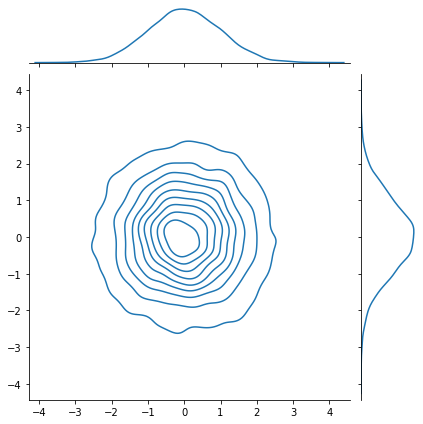

In [13]:
from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

Now, here's an example of a multivariate normal distribution that has covariance:
<pre>
Σ=( 2 −1
   −1  2 )
</pre>
And see how it looks:


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


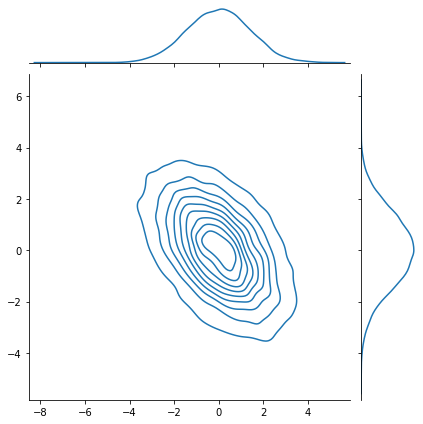

In [14]:


mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

Formula

Based on the paper, "The Fréchet distance between multivariate normal distributions" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions X
and Y

is:

<pre>
d(X,Y) = ∥μX − μY∥^2 + Tr(Σx + Σy −2√Σx * Σy)
</pre>
Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root. Tr
refers to the trace, the sum of the diagonal elements of a matrix.

In [15]:
import scipy
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    return (mu_x - mu_y).dot(mu_x - mu_y) + torch.trace(sigma_x) + torch.trace(sigma_y) - 2*torch.trace(matrix_sqrt(sigma_x @ sigma_y)) 

## Putting it all together

apply FID to your generator from earlier.

In [17]:
# helper code to preprocess the image for the Inception-v3 network

def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

# Function to calculate the covariance of the features that returns a covariance matrix given a list of values
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

use the pre-trained Inception-v3 model to compute features of the real and fake images. With these features, you can then get the covariance and means of these features across many samples.

First, you get the features of the real and fake images using the Inception-v3 model:

In [18]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

NameError: ignored

combine all of the values that you collected for the reals and fakes into large tensors:

In [ ]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

# Calculate the covariance matrix for the fake and real features and  means of the feature over the batch (for each feature dimension mean)

mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)



At this point, you can also visualize what the pairwise multivariate distributions of the inception features look like!


In [ ]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')



Lastly, we can use your earlier frechet_distance function to calculate the FID and evaluate your GAN. We can see how similar/different the features of the generated images are to the features of the real images. The next cell might take five minutes or so to run in Coursera.


In [ ]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())



We'll notice this model gets a pretty high FID, likely over 30. Since lower is better, and the best models on CelebA get scores in the single-digits, there's clearly a ways to go with this model. We can use FID to compare different models, as well as different stages of training of the same model.
